In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist



2024-08-05 13:35:11.283170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:35:11.283275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:35:11.423684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
(train_data,train_labels) , (test_data, test_labels) = mnist.load_data()

In [36]:
train_data.shape , train_labels.shape , test_data.shape , test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [37]:
class_names = ['0' , '1' , '2', '3' , '4' , '5' , '6' , '7' , '8' , '9']

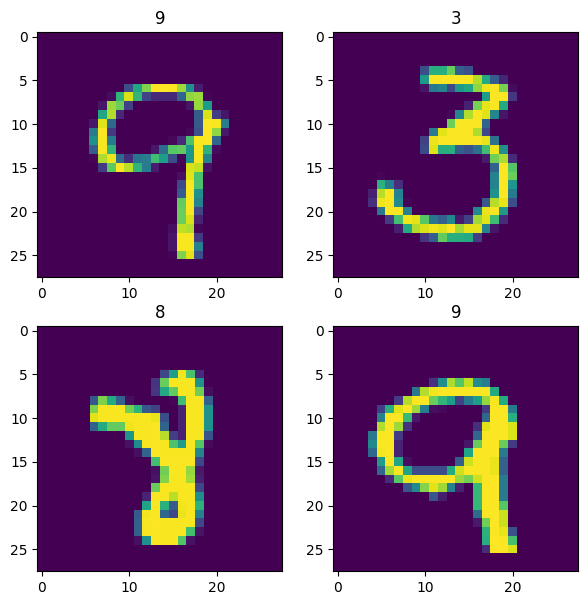

In [5]:
# Random images
import matplotlib.pyplot as plt
import random
plt.figure(figsize = (7, 7))
for i in range(4):
  ax = plt.subplot(2,2,i+1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index])
  plt.title(class_names[train_labels[rand_index]])

In [38]:
train_data.min() , train_data.max()

(0, 255)

In [39]:
train_data = train_data/255.
test_data = test_data/255.

train_data.min(), train_data.max()


(0.0, 1.0)

In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Calculate the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert the class weights to a dictionary
class_weights_dict = {i: class_weights[i] for i in np.unique(train_labels)}


In [11]:
class_weights_dict

{0: 1.0130001688333614,
 1: 0.8899436369029962,
 2: 1.0070493454179255,
 3: 0.978633175664655,
 4: 1.0270455323519343,
 5: 1.1068068622025458,
 6: 1.013856032443393,
 7: 0.9577015163607342,
 8: 1.025465732353444,
 9: 1.0085728693898135}

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import tensorflow_datasets as tfds

# MNISTLite model
def MNISTLite(input_shape, num_classes, num_channels, dim, expansion_ratio, num_layers=[2, 4, 3]):
    inputs = layers.Input(input_shape)

    # Stem
    x = layers.Conv2D(filters=num_channels[0], kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = inverted_residual_block(x, num_channels[1], strides=1, expansion_ratio=expansion_ratio)

    # Stage 1
    x = inverted_residual_block(x, num_channels[2], strides=2, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[3], strides=1, expansion_ratio=expansion_ratio)
    skip_1 = inverted_residual_block(x, num_channels[4], strides=1, expansion_ratio=expansion_ratio)

    # Stage 2
    x = inverted_residual_block(skip_1, num_channels[5], strides=2, expansion_ratio=expansion_ratio)
    skip_2 = mobile_vit_block(x, num_channels[6], dim[0], num_layers=num_layers[0])

    # Stage 3
    x = inverted_residual_block(skip_2, num_channels[7], strides=2, expansion_ratio=expansion_ratio)
    skip_3 = mobile_vit_block(x, num_channels[8], dim[1], num_layers=num_layers[1])

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

    return models.Model(inputs, x)

# Define inverted residual block (assuming you already have this function)
def inverted_residual_block(inputs, num_filters, strides=1, expansion_ratio=1):
    x = layers.Conv2D(filters=expansion_ratio * inputs.shape[-1], kernel_size=1, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.Conv2D(filters=num_filters, kernel_size=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if strides == 1 and inputs.shape == x.shape:
        return layers.Add()([inputs, x])
    return x

# Define mobile vit block (assuming you already have this function)
def mobile_vit_block(inputs, num_filters, dim, patch_size=2, num_layers=1):
    B, H, W, C = inputs.shape


    x = layers.SeparableConv2D(filters=num_filters, kernel_size=3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    return x

# Define transformer encoder (assuming you already have this function)
def transformer_encoder(x, num_heads, dim, mlp_dim):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)(x, x)
    x = layers.Add()([x, skip_1])

    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, mlp_dim, dim)
    x = layers.Add()([x, skip_2])

    return x

def mlp(x, mlp_dim, dim, dropout_rate=0.1):
    x = layers.Dense(mlp_dim, activation="swish")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x


In [22]:
input_shape = (28, 28,1)
num_classes = 10
model = MNISTLite(input_shape, num_classes, num_channels=[16, 16, 24, 24, 24, 48, 64, 64, 80], dim=[64, 80, 96], expansion_ratio=2, num_layers=[2, 4, 3])

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 14,    │        144 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 14, 14,    │        512 │ activation_15[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_6  │ (None, 14, 14,    │        288 │ activation_16[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 14, 14,    │        512 │ activation_17[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 14, 14,    │          0 │ activation_15[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 14, 14,    │        512 │ add_3[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_7  │ (None, 7, 7, 32)  │        288 │ activation_18[0]

 Total params: 37,882 (147.98 KB)

 Trainable params: 35,978 (140.54 KB)

 Non-trainable params: 1,904 (7.44 KB)

In [24]:


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])





In [25]:
history = model.fit(train_data , train_labels , epochs = 50 , validation_data = (test_data ,test_labels),class_weight=class_weights_dict,callbacks=[checkpoint_callback])

Epoch 1/50
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8595 - loss: 0.5769
Epoch 1: val_accuracy improved from -inf to 0.98180, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.8600 - loss: 0.5754 - val_accuracy: 0.9818 - val_loss: 0.1097
Epoch 2/50
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9825 - loss: 0.1093
Epoch 2: val_accuracy improved from 0.98180 to 0.98830, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9825 - loss: 0.1093 - val_accuracy: 0.9883 - val_loss: 0.0713
Epoch 3/50
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 0.0741
Epoch 3: val_accuracy improved from 0.98830 to 0.98950, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9882 - loss: 0.0741 - val_accuracy: 0.9895 - val_loss: 0.0612
Epoch 4/50
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9898 - loss: 0.0576
Epoch 4: val_accuracy di

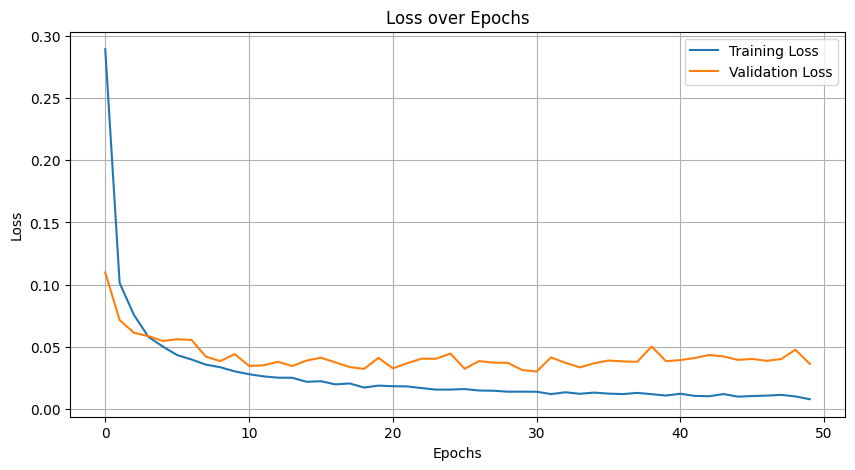

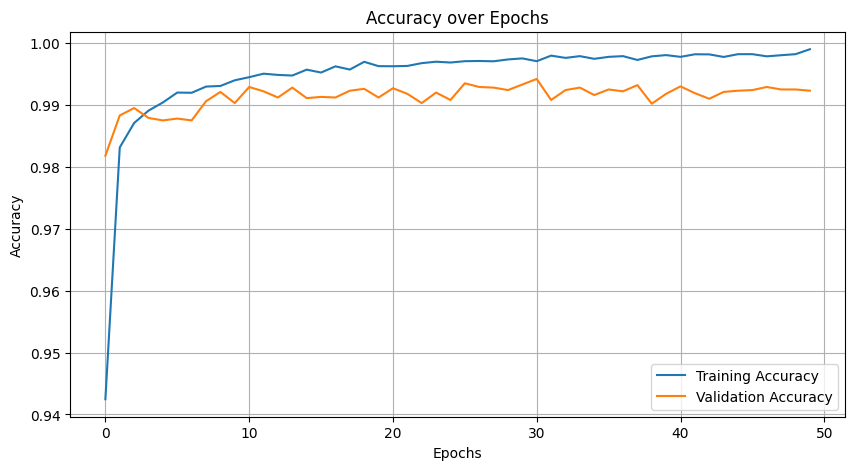

In [28]:
# Convert the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


# Load the best model
best_model = load_model('best_model.keras')

# Predict on the test data
predictions = best_model.predict(test_data)

# Calculate the accuracy
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

accuracy = np.mean(predicted_classes == true_classes)
print(f'Test accuracy: {accuracy:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test accuracy: 0.9942


In [44]:
predictions = model.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [45]:
predictions

array([[2.8188902e-06, 2.6562518e-06, 7.3924652e-06, ..., 9.9995220e-01,
        5.6591848e-06, 1.3589882e-06],
       [5.0663843e-08, 2.6551825e-07, 9.9996793e-01, ..., 2.3507459e-08,
        4.4753642e-06, 1.0532098e-05],
       [3.8477574e-06, 9.9995172e-01, 2.2681859e-06, ..., 7.1313707e-06,
        9.1748161e-06, 4.6278096e-06],
       ...,
       [5.9997574e-06, 1.4570271e-07, 1.7616921e-05, ..., 9.8352712e-06,
        2.6101850e-07, 1.0682318e-05],
       [4.8164379e-06, 4.0592918e-06, 1.0843923e-05, ..., 1.6767404e-05,
        7.0270995e-05, 2.8695072e-07],
       [2.3017010e-05, 9.7201868e-05, 1.2326075e-05, ..., 4.2692941e-06,
        1.5759788e-05, 4.2675583e-05]], dtype=float32)

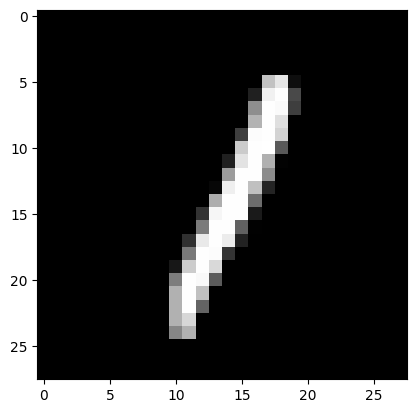

prediction :  1 Real :  1


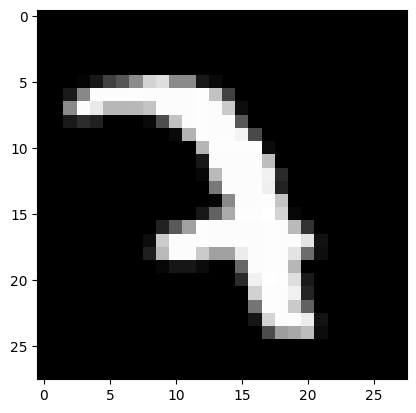

prediction :  7 Real :  7


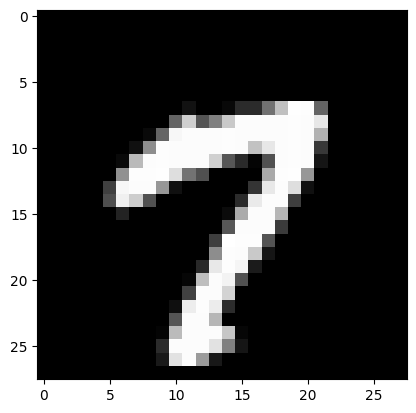

prediction :  7 Real :  7


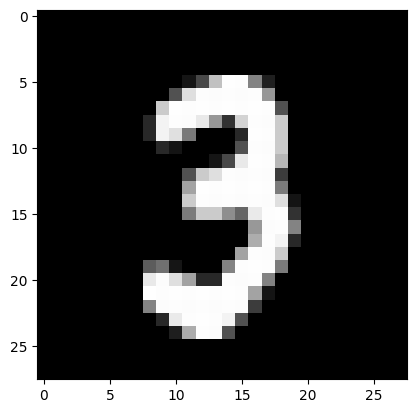

prediction :  3 Real :  3


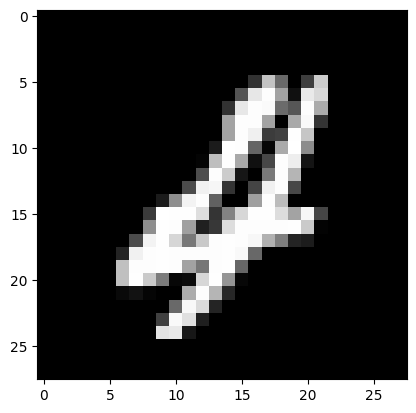

prediction :  4 Real :  4


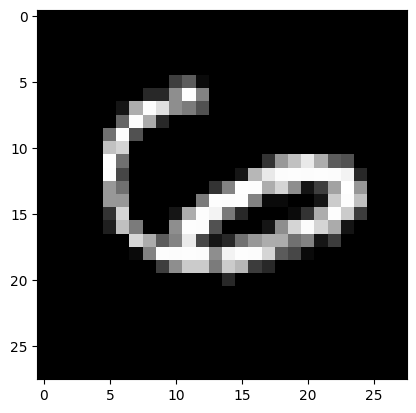

prediction :  6 Real :  6


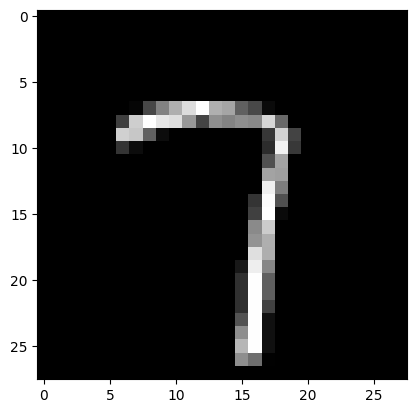

prediction :  7 Real :  7


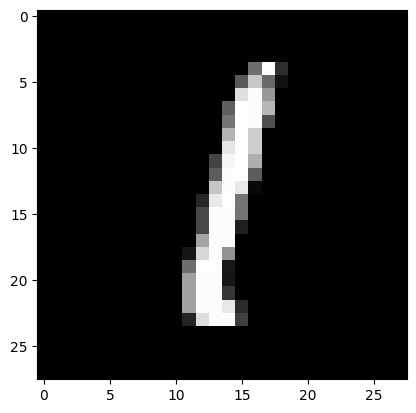

prediction :  1 Real :  1


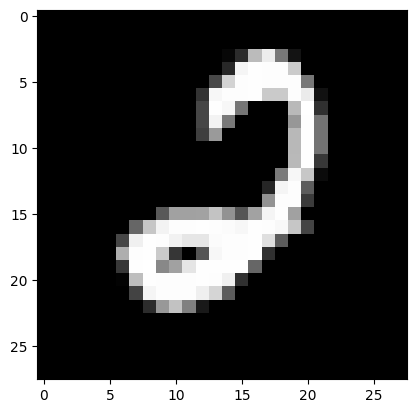

prediction :  2 Real :  2


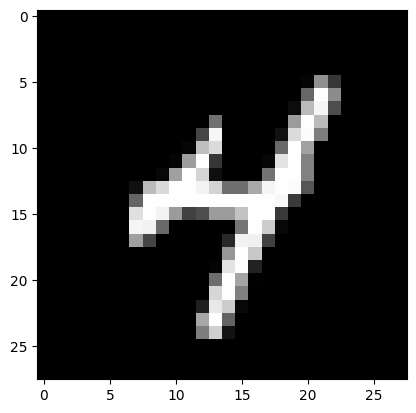

prediction :  4 Real :  4


In [46]:
import numpy as np
plt.gray()
for _ in range(10):
    random_no = np.random.randint(test_labels.shape[0])
    plt.imshow(test_data[random_no].reshape(28, 28))
    plt.show()
    pred = np.argmax(predictions[random_no])
    print("prediction : ",class_names[pred] , "Real : " , test_labels[random_no])